In [1]:
#project attempt 1:
#predicting victory type classification (resignation, mate, timeout, or draw) based on various game parameters in chess
#the data source is the online, matchmaking-based chess website lichess. Data was obtained via Kaggle at https://www.kaggle.com/datasnaek/chess
#will use simplified data regarding actual moves, i.e. regarding only opening move and opening strategy
#will consider some data external to the game, ie ratings and start time
#end result using random forest and decision tree is that the data used does not accurately predict the outcome class. at most, we obtain about 55-60% accuracy, even when using the training input data
#additionally, the models do not predict outoftime results
#random forest was used as essentially this comes down to a 4-class classification problem, one for each game end type, and so simple logistic regression would not work
#potential next steps would be: using multinomial logistic regression, neural network, etc for prediction. Further, larger datasets and careful treatment of data to obtain additional parameters (such as translating created_at time into 24-hour time using location data)
#intuitively, this also makes sense considering the data mostly takes into account only fairly shallow elements of end-game state as well as only the first few moves,
#and chess is a famously complex game

In [2]:
import pandas as pd
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data=pd.DataFrame(pd.read_csv('games.csv'))

In [4]:
data

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


In [45]:
data1=data.drop(labels=['id','last_move_at','white_id','black_id','moves','opening_name','created_at'],axis=1) #removing unimportant data (id, white id, black id) as well as redundant ('opening name' or 'opening_eco') or undesired 

In [46]:
data1.head()

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply
0,False,13,outoftime,white,15+2,1500,1191,D10,5
1,True,16,resign,black,5+10,1322,1261,B00,4
2,True,61,mate,white,5+10,1496,1500,C20,3
3,True,61,mate,white,20+0,1439,1454,D02,3
4,True,95,mate,white,30+3,1523,1469,C41,5


In [47]:

data1['rated']=data1['rated'].astype(int)
# data1['created_at']=data1['created_at'].astype(float)

In [48]:
code_lookup={}
result_lookup={}
opening_lookup={}
j=0
for i in data1['increment_code'].unique():
    code_lookup[i]=j
    j+=1
j=0
for i in data1['victory_status'].unique():
    result_lookup[i]=j
    j+=1
j=0
for i in data1['opening_eco'].unique():
    opening_lookup[i]=j
    j+=1

In [50]:
for i in range(len(data1['victory_status'])):
    a=data1['winner'][i]
    b=data1['victory_status'][i]
    c=data1['increment_code'][i]
    d=data1['opening_eco'][i]
    if a=='white':
        data1['winner'][i]=0
    elif a=='black':
        data1['winner'][i]=1
    elif a=='draw':
        data1['winner'][i]=2
    data1['victory_status'][i]=result_lookup[b]
    data1['increment_code'][i]=code_lookup[c]
    data1['opening_eco'][i]=opening_lookup[d]
    


<ipython-input-50-4574ffb9e01f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['winner'][i]=0
<ipython-input-50-4574ffb9e01f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['victory_status'][i]=result_lookup[b]
<ipython-input-50-4574ffb9e01f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['increment_code'][i]=code_lookup[c]
<ipython-input-50-4574ffb9e01f>:14: SettingWithCopyWarning: 
A value is trying to be se

In [51]:
data1['winner']=data1['winner'].astype(int)
data1['victory_status']=data1['victory_status'].astype(int)
data1['increment_code']=data1['increment_code'].astype(int)
data1['opening_eco']=data1['opening_eco'].astype(int)

In [52]:
data1.head()

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply
0,0,13,0,0,0,1500,1191,0,5
1,1,16,1,1,1,1322,1261,1,4
2,1,61,2,0,1,1496,1500,2,3
3,1,61,2,0,2,1439,1454,3,3
4,1,95,2,0,3,1523,1469,4,5


In [53]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(data1[['white_rating','black_rating']])
scaler.transform(data1[['white_rating','black_rating']])
data1[['white_rating','black_rating']]=scaler.transform(data1[['white_rating','black_rating']])


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test =train_test_split(data1.loc[:, data1.columns != 'victory_status'], data1['victory_status'], train_size=.8,random_state=123)

[Text(167.4, 181.2, 'X[2] <= 1.5\ngini = 0.582\nsamples = 16046\nvalue = [1365, 8938, 5023, 720]'),
 Text(83.7, 108.72, 'X[1] <= 45.5\ngini = 0.543\nsamples = 15288\nvalue = [1327, 8938, 5023, 0]'),
 Text(41.85, 36.23999999999998, 'gini = 0.462\nsamples = 5677\nvalue = [314, 3880, 1483, 0]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.576\nsamples = 9611\nvalue = [1013, 5058, 3540, 0]'),
 Text(251.10000000000002, 108.72, 'X[1] <= 112.5\ngini = 0.095\nsamples = 758\nvalue = [38, 0, 0, 720]'),
 Text(209.25, 36.23999999999998, 'gini = 0.026\nsamples = 531\nvalue = [7, 0, 0, 524]'),
 Text(292.95, 36.23999999999998, 'gini = 0.236\nsamples = 227\nvalue = [31, 0, 0, 196]')]

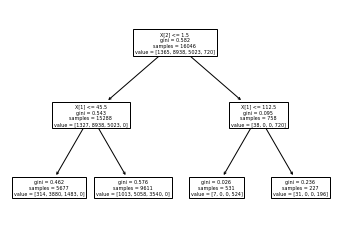

In [55]:
from sklearn.tree import DecisionTreeClassifier
model_DT=DecisionTreeClassifier(max_depth=2,criterion='gini').fit(X_train,Y_train)
from sklearn import tree
tree.plot_tree(model_DT)

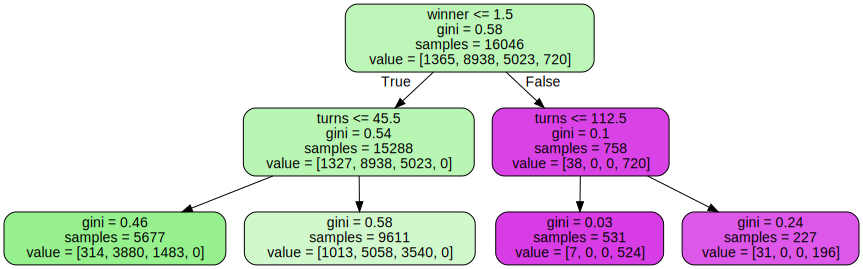

In [56]:
import graphviz
dot_data = tree.export_graphviz(model_DT, out_file=None, 
                feature_names = X_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
graph = graphviz.Source(dot_data) 
graph

In [57]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
Y_pred_DT=model_DT.predict(X_test)
metrics.accuracy_score(Y_test,Y_pred_DT)

0.5969591226321037

In [58]:
model_RF=RandomForestClassifier(n_estimators=100,max_depth=5,criterion='gini').fit(X_train,Y_train)

In [59]:


Y_pred_RF=model_RF.predict(X_test)

metrics.accuracy_score(Y_test,Y_pred_RF)

0.6126620139581256

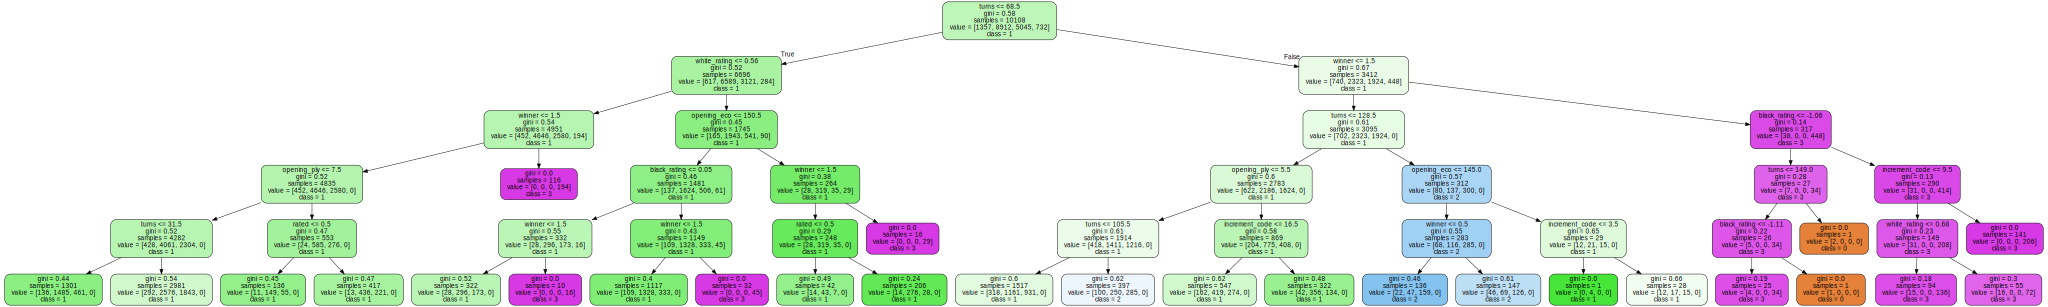

In [60]:
estimator = model_RF.estimators_[0]
dot_data = tree.export_graphviz(estimator, out_file=None, 
                feature_names = X_train.columns,
                class_names = '0123',
                rounded = True, proportion = False, 
                precision = 2, filled = True)
graph = graphviz.Source(dot_data) 
graph

In [61]:
metrics.accuracy_score(Y_test,Y_pred_RF)

0.6126620139581256

In [62]:
np.unique(Y_test)

array([0, 1, 2, 3])

In [63]:
np.unique(Y_pred_RF)

array([1, 2, 3])

In [64]:
result_lookup

{'outoftime': 0, 'resign': 1, 'mate': 2, 'draw': 3}